#Libraries

In [1]:
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from imutils import paths
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.nn import softmax 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import cv2
from skimage.metrics import structural_similarity as ssim


2024-11-15 14:16:37.640884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-11-15 14:16:41.235433: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-15 14:16:41.236365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-15 14:16:41.250993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-15 14:16:41.251238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P2000 computeCapability: 6.1
coreClock: 1.607GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 89.53GiB/s
2024-11-15 14:16:41.251277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-15 14:16:41.317241: I tensorflow/stream_executor/platform/default/dso_loa

In [3]:
# Reading FRI Images
imagePaths = list(paths.list_images(r"/home/gunner/Dataset/FR0"))

data = []
data_cropped = []
labels = []
label = 0
counter_0 = 0

for imagePath in imagePaths:
  image = tf.io.read_file(imagePath)
  image = tf.image.decode_image(image, channels=1)
  data.append(image)
  labels.append(label)
  counter_0 += 1
print(f'Loaded FR0... {counter_0} files has loaded.')

2024-11-15 14:16:41.560983: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 14:16:41.562671: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-15 14:16:41.562916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-15 14:16:41.563058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P2000 computeCapability: 6.1
coreClock: 1.607GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 89.53GiB/s
2024-11-

Loaded FR0... 6066 files has loaded.


In [4]:
# Reading FRI Images
imagePaths = list(paths.list_images(r"/home/gunner/Dataset/FRI"))


label = 1
counter_1 = 0

for imagePath in imagePaths:
  image = tf.io.read_file(imagePath)
  image = tf.image.decode_image(image, channels=1)
  data.append(image)
  labels.append(label)
  counter_1 += 1
print(f'Loaded FRI... {counter_1} files has loaded.')

Loaded FRI... 5008 files has loaded.


In [5]:
# Reading FRI Images
imagePaths = list(paths.list_images(r"/home/gunner/Dataset/FRII"))

label = 2
counter_2 = 0

for imagePath in imagePaths:
  image = tf.io.read_file(imagePath)
  image = tf.image.decode_image(image, channels=1)
  data.append(image)
  labels.append(label)
  counter_2 += 1
print(f'Loaded FRII... {counter_2} files has loaded.')

Loaded FRII... 2066 files has loaded.


#**Cropping**

In [6]:
data_cropped_ResNet = []
for image in data:
  image = tf.image.crop_to_bounding_box(image, 38, 38, 224, 224)
  data_cropped_ResNet.append(image)


In [7]:
labels = np.array(labels,dtype='uint8')
data = np.array(data,dtype='uint8')
data_cropped_ResNet = np.array(data_cropped_ResNet,dtype='uint8')

#**Filterring**

In [8]:
data_cropped_ResNet.shape, labels.shape

((13140, 224, 224, 1), (13140,))

In [9]:
mask = np.array([np.max(image) >= 5 for image in data_cropped_ResNet])
filtered_data = data_cropped_ResNet[mask]
filtered_labels = labels[mask]

In [10]:
mask_useless = np.array([np.max(image) < 5 for image in data_cropped_ResNet])
useless_data = data_cropped_ResNet[mask_useless]
useless_labels = labels[mask_useless]

In [11]:
class_0_useless = useless_data[useless_labels == 0]
class_1_useless = useless_data[useless_labels == 1]
class_2_useless = useless_data[useless_labels == 2]

In [12]:
np.max(class_0_useless), np.max(class_1_useless), np.max(class_2_useless)

(2, 0, 4)

In [13]:
class_0_useless.shape, class_1_useless.shape, class_2_useless.shape

((18, 224, 224, 1), (22, 224, 224, 1), (13, 224, 224, 1))

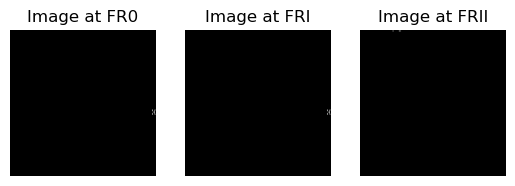

In [14]:
temp = 0
for i in class_0_useless:
  if np.max(i) >temp:
    temp = np.max(i)
    image = np.squeeze(i)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f"Image at FR0")

temp = 0
for i in class_1_useless:
  if np.max(i) >temp:
    temp = np.max(i)
    image = np.squeeze(i)
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f"Image at FRI")

temp = 0
for i in class_2_useless:
  if np.max(i) >temp:
    temp = np.max(i)
    image = np.squeeze(i)
plt.subplot(1, 3, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f"Image at FRII")


plt.show()

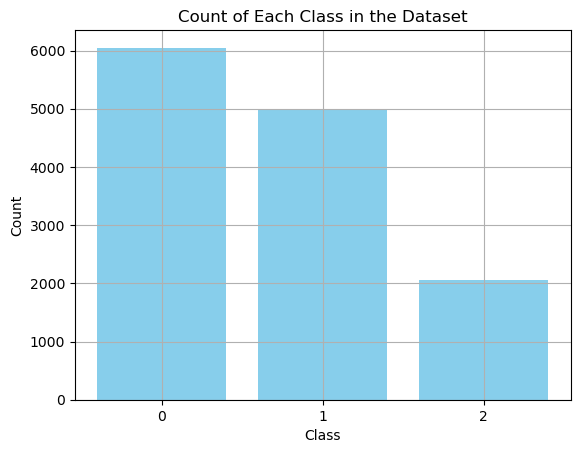

In [15]:
counter = Counter(filtered_labels)
sorted_counts = dict(sorted(counter.items()))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.grid(True)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Each Class in the Dataset')
plt.xticks(range(3))
plt.show()

In [16]:
class_0_image = filtered_data[filtered_labels == 0]
class_1_image = filtered_data[filtered_labels == 1]
class_2_image = filtered_data[filtered_labels == 2]
class_0_image.shape, class_1_image.shape, class_2_image.shape

((6048, 224, 224, 1), (4986, 224, 224, 1), (2053, 224, 224, 1))

#**Augmentation**

In [17]:
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
class_2_data = filtered_data[filtered_labels == 2]
class_1_data = filtered_data[filtered_labels == 1]


augmented_class_2_data = []
augmented_class_2_labels = []

for i in range(4000):
    image = class_2_data[np.random.randint(0, len(class_2_data))]
    augmented_image = datagen.random_transform(image)
    augmented_class_2_data.append(augmented_image)
    augmented_class_2_labels.append(2)



augmented_class_1_data = []
augmented_class_1_labels = []

for i in range(1000):
    image = class_1_data[np.random.randint(0, len(class_1_data))]
    augmented_image = datagen.random_transform(image)
    augmented_class_1_data.append(augmented_image)
    augmented_class_1_labels.append(1)



In [18]:
augmented_class_2_data = np.array(augmented_class_2_data)
augmented_class_2_labels = np.array(augmented_class_2_labels)

augmented_class_1_data = np.array(augmented_class_1_data)
augmented_class_1_labels = np.array(augmented_class_1_labels)

final_data = np.concatenate((filtered_data, augmented_class_2_data, augmented_class_1_data), axis=0)
final_labels = np.concatenate((filtered_labels, augmented_class_2_labels, augmented_class_1_labels), axis=0)

In [19]:
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Final data shape: (18087, 224, 224, 1)
Final labels shape: (18087,)


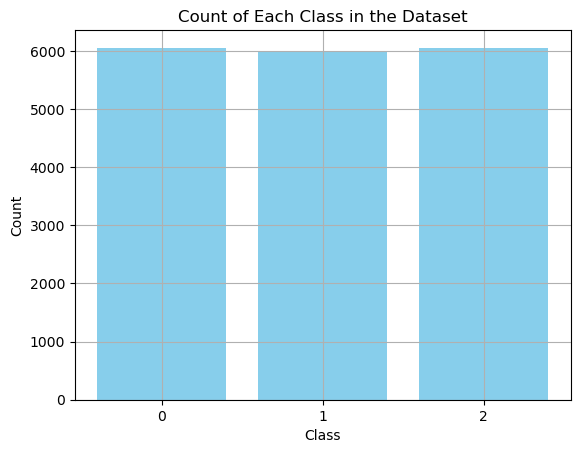

In [20]:
counter = Counter(final_labels)
sorted_counts = dict(sorted(counter.items()))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.grid(True)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Each Class in the Dataset')
plt.xticks(range(3))
plt.show()

In [21]:
class_0_flatten = []
class_1_flatten = []
class_2_flatten = []


for image in final_data[final_labels == 0]:
    class_0_flatten.append(image.flatten())

for image in final_data[final_labels == 1]:
    class_1_flatten.append(image.flatten())

for image in final_data[final_labels == 2]:
    class_2_flatten.append(image.flatten())


class_0_flatten = np.array(class_0_flatten, dtype='uint8')
class_1_flatten = np.array(class_1_flatten, dtype='uint8')
class_2_flatten = np.array(class_2_flatten, dtype='uint8')

class_0_flatten.shape, class_1_flatten.shape, class_2_flatten.shape, final_data.shape, final_labels.shape

((6048, 50176), (5986, 50176), (6053, 50176), (18087, 224, 224, 1), (18087,))

#**Sobel**

In [22]:
class_0_image = final_data[final_labels == 0]
class_1_image = final_data[final_labels == 1]
class_2_image = final_data[final_labels == 2]

In [23]:
class_0_image.shape, class_1_image.shape, class_2_image.shape

((6048, 224, 224, 1), (5986, 224, 224, 1), (6053, 224, 224, 1))

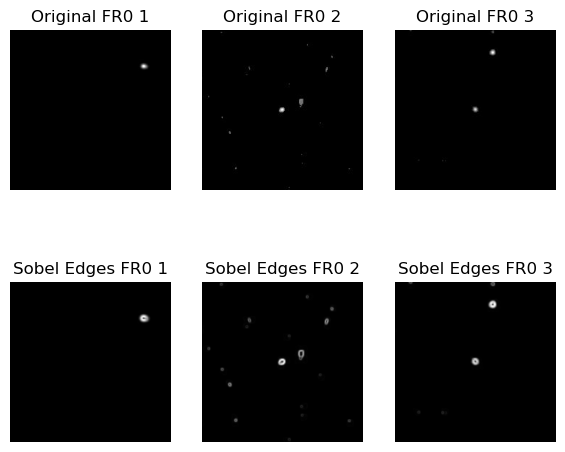

In [24]:
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
edge_image = np.sqrt(sobel_x**2 + sobel_y**2)

plt.figure(figsize=(12, 6))
for i in range(3):
    image = class_0_image[i]
    sobel_x = cv2.Sobel(class_0_image[i], cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(class_0_image[i], cv2.CV_64F, 0, 1, ksize=5)   
    edge_image = np.sqrt(sobel_x**2 + sobel_y**2)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original FR0 {i+1}")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(edge_image, cmap='gray')
    plt.title(f"Sobel Edges FR0 {i+1}")
    plt.axis('off')

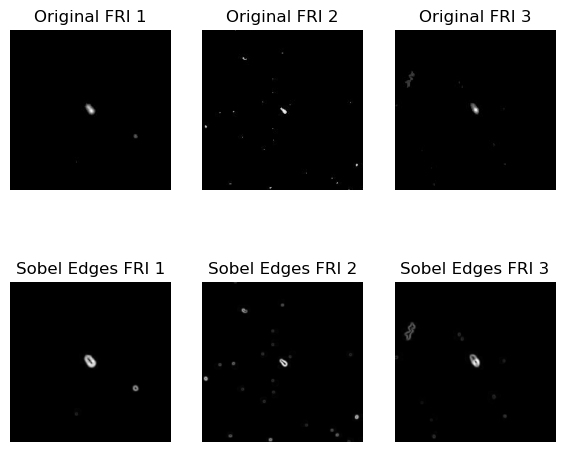

In [25]:
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
edge_image = np.sqrt(sobel_x**2 + sobel_y**2)

plt.figure(figsize=(12, 6))
for i in range(3):
    image = class_1_image[i]
    sobel_x = cv2.Sobel(class_1_image[i], cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(class_1_image[i], cv2.CV_64F, 0, 1, ksize=5)   
    edge_image = np.sqrt(sobel_x**2 + sobel_y**2)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original FRI {i+1}")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(edge_image, cmap='gray')
    plt.title(f"Sobel Edges FRI {i+1}")
    plt.axis('off')

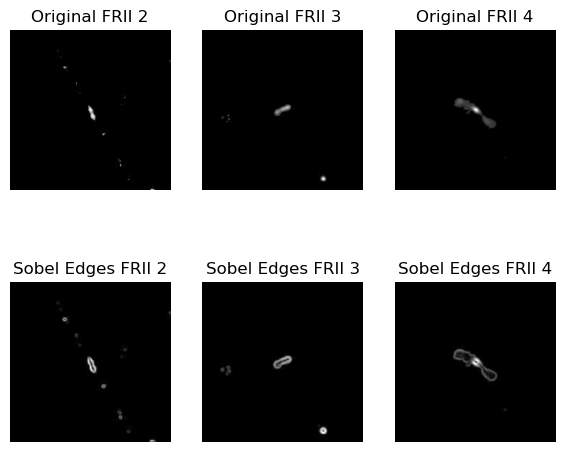

In [26]:
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
edge_image = np.sqrt(sobel_x**2 + sobel_y**2)

plt.figure(figsize=(12, 6))
for i in range(1, 4):
    image = class_2_image[i]
    sobel_x = cv2.Sobel(class_2_image[i], cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(class_2_image[i], cv2.CV_64F, 0, 1, ksize=5)   
    edge_image = np.sqrt(sobel_x**2 + sobel_y**2)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original FRII {i+1}")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(edge_image, cmap='gray')
    plt.title(f"Sobel Edges FRII {i+1}")
    plt.axis('off')

#**Symmetry**

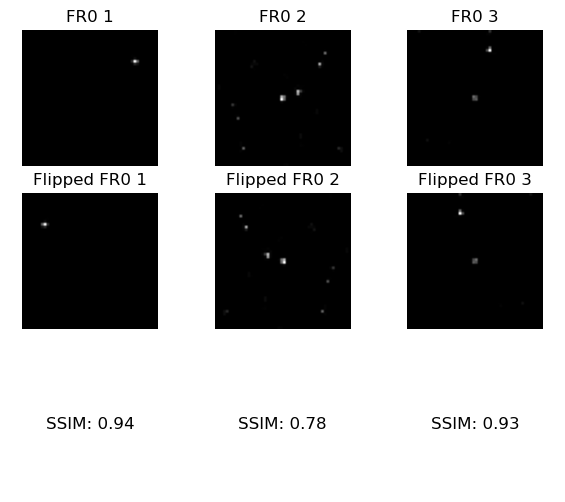

In [27]:
plt.figure(figsize=(12, 6))
for i in range(3):
    image = class_0_image[i]
    image = cv2.resize(image, (50, 50))  

    flipped_image = cv2.flip(image, 1)

    symmetry_score, _ = ssim(image, flipped_image, full=True)


    # Original Image
    plt.subplot(3, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"FR0 {i+1}")
    plt.axis('off')

    # Flipped Image
    flipped_image = cv2.flip(image, 1)
    plt.subplot(3, 5, i+6)
    plt.imshow(flipped_image, cmap='gray')
    plt.title(f"Flipped FR0 {i+1}")
    plt.axis('off')

    # Symmetry Score
    plt.subplot(3, 5, i+11)
    plt.text(0.5, 0.5, f"SSIM: {symmetry_score:.2f}", ha='center', va='center', fontsize=12)
    plt.axis('off')

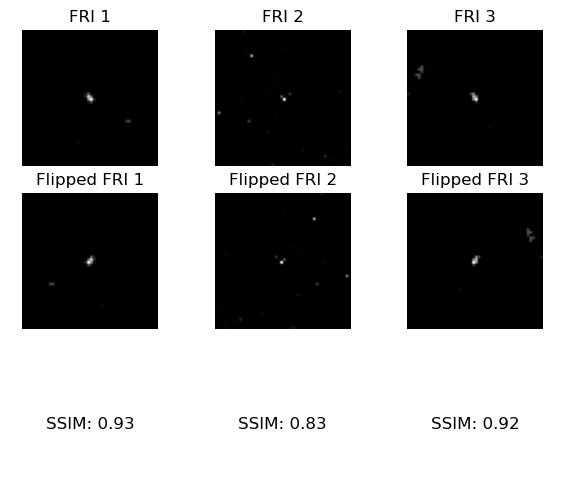

In [28]:
plt.figure(figsize=(12, 6))
for i in range(3):
    image = class_1_image[i]
    image = cv2.resize(image, (50, 50))  

    flipped_image = cv2.flip(image, 1)

    symmetry_score, _ = ssim(image, flipped_image, full=True)


    # Original Image
    plt.subplot(3, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"FRI {i+1}")
    plt.axis('off')

    # Flipped Image
    flipped_image = cv2.flip(image, 1)
    plt.subplot(3, 5, i+6)
    plt.imshow(flipped_image, cmap='gray')
    plt.title(f"Flipped FRI {i+1}")
    plt.axis('off')

    # Symmetry Score
    plt.subplot(3, 5, i+11)
    plt.text(0.5, 0.5, f"SSIM: {symmetry_score:.2f}", ha='center', va='center', fontsize=12)
    plt.axis('off')

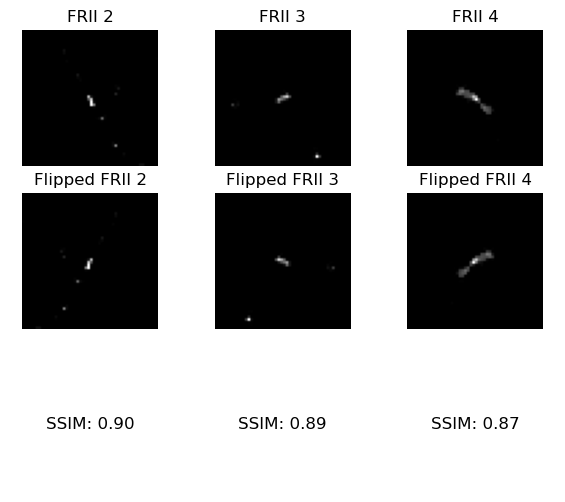

In [29]:
plt.figure(figsize=(12, 6))
for i in range(1, 4):
    image = class_2_image[i]
    image = cv2.resize(image, (50, 50))  

    flipped_image = cv2.flip(image, 1)

    symmetry_score, _ = ssim(image, flipped_image, full=True)


    # Original Image
    plt.subplot(3, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"FRII {i+1}")
    plt.axis('off')

    # Flipped Image
    flipped_image = cv2.flip(image, 1)
    plt.subplot(3, 5, i+6)
    plt.imshow(flipped_image, cmap='gray')
    plt.title(f"Flipped FRII {i+1}")
    plt.axis('off')

    # Symmetry Score
    plt.subplot(3, 5, i+11)
    plt.text(0.5, 0.5, f"SSIM: {symmetry_score:.2f}", ha='center', va='center', fontsize=12)
    plt.axis('off')

In [30]:
flipped_class_0_scores = []

for i in class_0_image:
    image = cv2.resize(i, (50, 50))  
    flipped_image = cv2.flip(image, 1)
    symmetry_score, _ = ssim(image, flipped_image, full=True)
    flipped_class_0_scores.append(symmetry_score)

flipped_class_0_scores = np.array(flipped_class_0_scores)
flipped_class_0_scores_mean = np.mean(flipped_class_0_scores)
flipped_class_0_scores.shape

(6048,)

In [31]:
flipped_class_1_scores = []

for i in class_1_image:
    image = cv2.resize(i, (50, 50))  
    flipped_image = cv2.flip(image, 1)
    symmetry_score, _ = ssim(image, flipped_image, full=True)
    flipped_class_1_scores.append(symmetry_score)

flipped_class_1_scores = np.array(flipped_class_1_scores)
flipped_class_1_scores_mean = np.mean(flipped_class_1_scores)
flipped_class_1_scores.shape

(5986,)

In [32]:
flipped_class_2_scores = []

for i in class_2_image:
    image = cv2.resize(i, (50, 50))  
    flipped_image = cv2.flip(image, 1)
    symmetry_score, _ = ssim(image, flipped_image, full=True)
    flipped_class_2_scores.append(symmetry_score)

flipped_class_2_scores = np.array(flipped_class_2_scores)
flipped_class_2_scores_mean = np.mean(flipped_class_2_scores)
flipped_class_2_scores.shape


(6053,)

FR0 numbers: (6048,) , FRI Numbers: (5986,), FRII Numbers: (6053,)
FR0 Symmetry Score: 0.94 , FRI Symmetry Score: 0.91, FRII Symmetry Score: 0.88


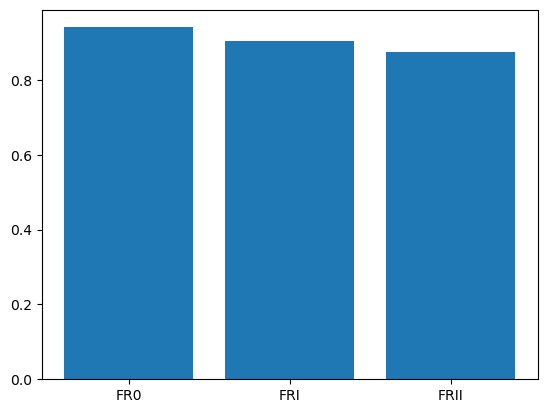

In [33]:
print(f'FR0 numbers: {flipped_class_0_scores.shape} , FRI Numbers: {flipped_class_1_scores.shape}, FRII Numbers: {flipped_class_2_scores.shape}')
print(f'FR0 Symmetry Score: {flipped_class_0_scores_mean:0.2f} , FRI Symmetry Score: {flipped_class_1_scores_mean:0.2f}, FRII Symmetry Score: {flipped_class_2_scores_mean:0.2f}')


flipped_labels = ['FR0', 'FRI', 'FRII']
flipped_values = [flipped_class_0_scores_mean, flipped_class_1_scores_mean, flipped_class_2_scores_mean]
plt.bar(flipped_labels, flipped_values)
plt.show()



#**Preprocessing**

In [34]:
np.min(final_data[0]), np.max(final_data[0])

(0, 251)

In [35]:
data_normalized = final_data / 255

In [36]:
print(f'Min of original = {np.min(final_data[0])}')
print(f'Max of original = {np.max(final_data[0])}')
print(f'Min of original = {np.min(data_normalized[0])}')
print(f'Max of original = {np.max(data_normalized[0])}')

Min of original = 0
Max of original = 251
Min of original = 0.0
Max of original = 0.984313725490196


#***An explanation about the data frames***

#**data_cropped -->> filtered_data -->> final_data -->> data_normalized**

#**labels -->> filtered_labels -->> final_labels**

#**Splitting**

In [ ]:
x = data_normalized
y = final_labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

#**CNN**

In [84]:
model_cnn = keras.Sequential()

#Seed
tf.random.set_seed(42)

#CNN
model_cnn.add(keras.layers.Conv2D(16, kernel_size=(3,3), input_shape=(60, 60, 1)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(32, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(32, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(64, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(keras.layers.Conv2D(64, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Conv2D(128, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_cnn.add(keras.layers.Conv2D(128, kernel_size=(3,3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))
model_cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2)))


#Dense
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(units=24, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.5))



#Output
model_cnn.add(keras.layers.Dense(units=3, activation=keras.activations.softmax))


#Model Compiling
optimizer = keras.optimizers.Adam(learning_rate=0.00002)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = [keras.metrics.CategoricalAccuracy()]

model_cnn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


#Builing and Summury
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 58, 58, 16)        160       
_________________________________________________________________
batch_normalization_53 (Batc (None, 58, 58, 16)        64        
_________________________________________________________________
activation_53 (Activation)   (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
batch_normalization_54 (Batc (None, 56, 56, 32)        128       
_________________________________________________________________
activation_54 (Activation)   (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 54, 54, 32)       

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

In [86]:
start = time.perf_counter()
hist = model_cnn.fit(x_train, y_train, batch_size=512, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
end = time.perf_counter()

Epoch 1/100


2024-11-15 13:17:29.461010: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


25/25 [==============================] - 65s 2s/step - loss: 1.5322 - accuracy: 0.3709 - val_loss: 1.1004 - val_accuracy: 0.3328
Epoch 2/100
25/25 [==============================] - 16s 635ms/step - loss: 1.0215 - accuracy: 0.5136 - val_loss: 1.1063 - val_accuracy: 0.3328
Epoch 3/100
25/25 [==============================] - 16s 634ms/step - loss: 0.8904 - accuracy: 0.5829 - val_loss: 1.1162 - val_accuracy: 0.3328
Epoch 4/100
25/25 [==============================] - 16s 635ms/step - loss: 0.8074 - accuracy: 0.6236 - val_loss: 1.1256 - val_accuracy: 0.3328
Epoch 5/100
25/25 [==============================] - 16s 635ms/step - loss: 0.7644 - accuracy: 0.6636 - val_loss: 1.1353 - val_accuracy: 0.3328
Epoch 6/100
25/25 [==============================] - 16s 634ms/step - loss: 0.7250 - accuracy: 0.6806 - val_loss: 1.1378 - val_accuracy: 0.3328
Epoch 7/100
25/25 [==============================] - 16s 634ms/step - loss: 0.7176 - accuracy: 0.6845 - val_loss: 1.1369 - val_accuracy: 0.3328
Epoch 8

In [70]:
(end - start)/ 60

13.702294383133333

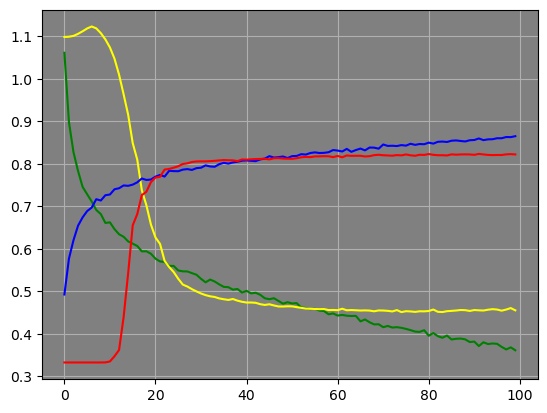

In [71]:
acc_train = hist.history['accuracy']
acc_test = hist.history['val_accuracy']
loss_train = hist.history['loss']
loss_test = hist.history['val_loss']

plt.axes().set_facecolor('gray')
plt.grid('True')


plt.plot(loss_train, color='green', label='Train loss')
plt.plot(loss_test, color='yellow', label='Test loss')
plt.plot(acc_train, color='blue', label='Train acc')
plt.plot(acc_test, color='red', label='Test acc')


plt.show()

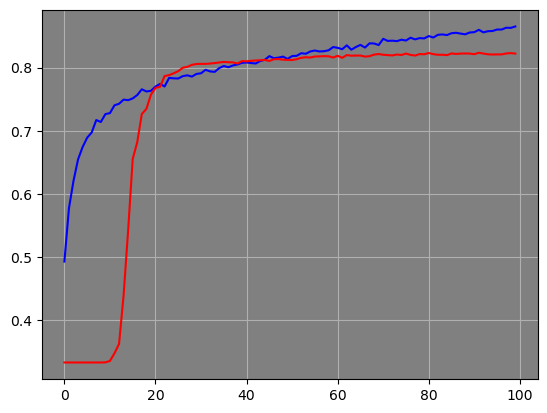

In [72]:
acc_train = hist.history['accuracy']
acc_test = hist.history['val_accuracy']

plt.axes().set_facecolor('gray')
plt.grid('True')


plt.plot(acc_train, color='blue', label='Train acc');
plt.plot(acc_test, color='red', label='Test acc');


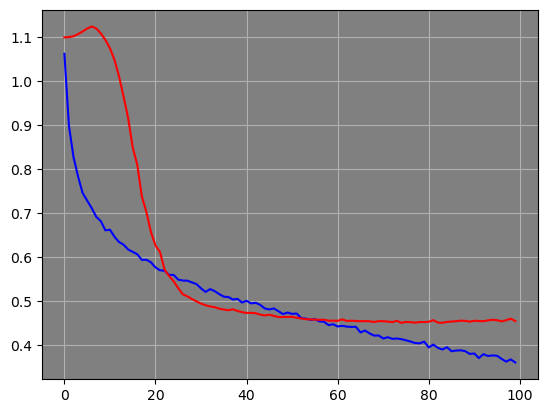

In [73]:
loss_train = hist.history['loss']
loss_test = hist.history['val_loss']

plt.axes().set_facecolor('gray')
plt.grid('True')


plt.plot(loss_train, color='blue', label='Train loss');
plt.plot(loss_test, color='red', label='Test loss');



In [87]:
model_cnn.evaluate(x=x_train, y=y_train)
model_cnn.evaluate(x=x_test, y=y_test)

169/169 [==============================] - 9s 55ms/step - loss: 0.4521 - accuracy: 0.8280


[0.4521467685699463, 0.8280467391014099]

In [88]:
from sklearn.metrics import classification_report
y_pred = model_cnn.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

# Print classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1809
           1       0.78      0.71      0.74      1788
           2       0.82      0.86      0.84      1794

    accuracy                           0.83      5391
   macro avg       0.83      0.83      0.83      5391
weighted avg       0.83      0.83      0.83      5391



In [89]:
y_pred_train = model_cnn.predict(x_train)
y_pred_test = model_cnn.predict(x_test)


index_train = random.randint(0, 12579)
print(f'y_train: {y_train[index_train]} y_pred_train:{y_pred_train[index_train]}')

index_test = random.randint(0, 5391)
print(f'y_test: {y_test[index_test]} y_pred_test:{y_pred_test[index_test]}')


y_train: 2 y_pred_train:[8.575009e-06 7.207528e-03 9.927839e-01]
y_test: 2 y_pred_test:[1.1411451e-05 3.2461483e-02 9.6752709e-01]


In [90]:
y_pred_train_smax = softmax(y_pred_train, axis=1)
y_pred_test_smax = softmax(y_pred_test, axis=1)

y_pred_train_smax = np.argmax(y_pred_train_smax, axis=1)
y_pred_test_smax = np.argmax(y_pred_test_smax, axis=1)


y_pred_test_smax.shape, y_pred_train_smax.shape

((5391,), (12579,))

In [91]:
acc_train = accuracy_score(y_train, y_pred_train_smax)
acc_test = accuracy_score(y_test, y_pred_test_smax)

p = precision_score(y_test, y_pred_test_smax, average='micro')
r = recall_score(y_test, y_pred_test_smax, average='micro')


print(f'Acc Train: {acc_train} - Acc Test: {acc_test} - Percision: {p} - Recall: {r}')

Acc Train: 0.924556801017569 - Acc Test: 0.8280467445742905 - Percision: 0.8280467445742905 - Recall: 0.8280467445742905


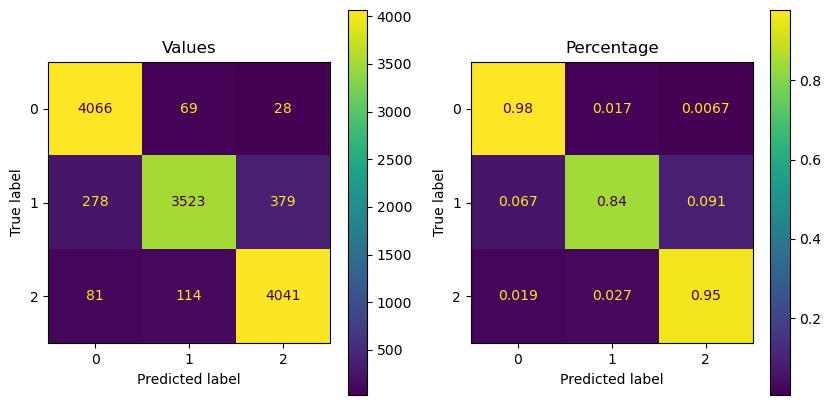

In [92]:
cm_train = confusion_matrix(y_true=y_train, y_pred=y_pred_train_smax)
disp_cm_train = ConfusionMatrixDisplay(cm_train)

cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
disp_cm_train_perce = ConfusionMatrixDisplay(cm_train)


fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Values')
ax2.set_title('Percentage')
disp_cm_train.plot(ax=ax1);
disp_cm_train_perce.plot(ax=ax2);

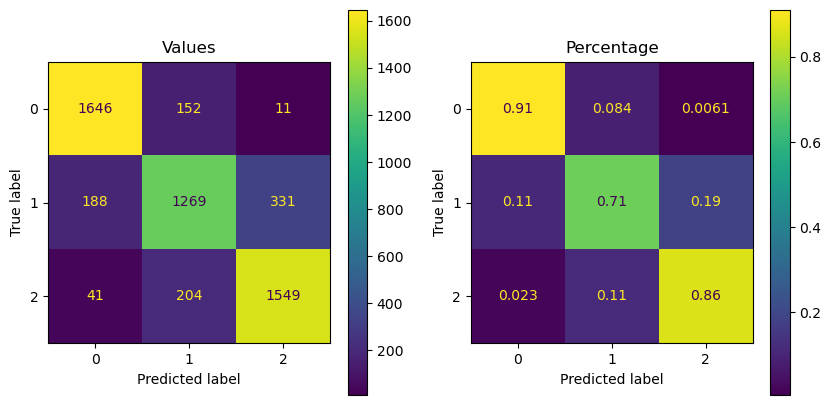

In [93]:
cm_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test_smax)
disp_cm_test = ConfusionMatrixDisplay(cm_test)

cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
disp_cm_test_perce = ConfusionMatrixDisplay(cm_test)


fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Values')
ax2.set_title('Percentage')
disp_cm_test.plot(ax=ax1);
disp_cm_test_perce.plot(ax=ax2);